# Throughput

## Import Data

In [40]:
import json
import os, glob
import pandas as pd
import pandas.io.json as pdjson
import seaborn as sns

sns.set(style="whitegrid")

In [41]:
data_frames = []

for file in glob.glob("*_1.orun.summary.bench"):
    with open(file) as f:
        data = []
        for l in f:
            temp = json.loads(l)
            if 'name' in temp:
                data.append(temp)
        df = pd.json_normalize(data)
        df['variant'] = file.replace("_1.orun.summary.bench","")
        data_frames.append(df)

df = pd.concat (data_frames, sort=False)
df = df.sort_values(['name']) 
# Uncomment the following to display all the lines in pandas output
pd.set_option('display.max_rows', df.shape[0]+1)
df

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.minor_words,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.forced_major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant
9,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.011007,3.974770,0.035988,30224,142329.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,2155870555,242,4194616,8229,6,0,3198985,4247564,3302.926734,5.00+stable+sequential
9,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.000723,3.988472,0.012001,30096,142323.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,2155870555,242,4194616,8229,6,0,3198985,4247564,3302.926734,5.00+trunk+sequential
20,alt-ergo.fill.why,taskset --cpu-list 5 alt-ergo benchmarks/alt-e...,2.273756,2.091136,0.182357,441648,2785481.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,179629427,56199547,60794131,700,15,0,54394248,54394248,5.755168,5.00+stable+sequential
20,alt-ergo.fill.why,taskset --cpu-list 5 alt-ergo benchmarks/alt-e...,2.265809,1.989361,0.276188,442244,2785751.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,179629429,56216116,60810700,700,15,0,54484360,54484360,5.698493,5.00+trunk+sequential
11,alt-ergo.yyll.why,taskset --cpu-list 5 alt-ergo benchmarks/alt-e...,17.761735,17.517296,0.244018,341680,2785481.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,2053015097,66209057,83473786,7852,21,0,41454596,41454596,30.378254,5.00+stable+sequential
11,alt-ergo.yyll.why,taskset --cpu-list 5 alt-ergo benchmarks/alt-e...,17.870233,17.686257,0.182503,341156,2785751.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,2053015012,66013648,83278335,7853,21,0,41479172,41479172,30.326962,5.00+trunk+sequential
31,bdd.26,taskset --cpu-list 5 ./bdd.exe 26,5.503680,5.479402,0.024014,22616,194141.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,1227749947,1952179,2484347,4695,10,0,2027158,2092697,23.657402,5.00+trunk+sequential
31,bdd.26,taskset --cpu-list 5 ./bdd.exe 26,5.117265,5.100994,0.016003,22640,194147.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,1227749947,1952179,2484347,4695,10,0,2027158,2092697,23.657402,5.00+stable+sequential
36,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,10.694697,10.614400,0.079987,217248,324296.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,916456774,280496186,280496252,3542,46,0,23392256,27054080,50.289195,5.00+trunk+sequential
36,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,10.628480,10.496177,0.132002,217208,324302.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,916456774,280496186,280496252,3542,46,0,23392256,27054080,50.289195,5.00+stable+sequential


### Drop some benchmarks


In [42]:
df = df[(df.name != 'alt-ergo.fill.why') &         #multicore version does not exist
        (df.name != 'alt-ergo.yyll.why') &         #multicore version does not exist
        (df.name != 'frama-c.slevel') &            #multicore version does not exist
        (df.name != 'js_of_ocaml.frama-c_byte')]   #multicore version does not exist
throughput_df = df
df

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.minor_words,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.forced_major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant
9,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.011007,3.974770,0.035988,30224,142329.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,2155870555,242,4194616,8229,6,0,3198985,4247564,3302.926734,5.00+stable+sequential
9,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.000723,3.988472,0.012001,30096,142323.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,2155870555,242,4194616,8229,6,0,3198985,4247564,3302.926734,5.00+trunk+sequential
31,bdd.26,taskset --cpu-list 5 ./bdd.exe 26,5.503680,5.479402,0.024014,22616,194141.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,1227749947,1952179,2484347,4695,10,0,2027158,2092697,23.657402,5.00+trunk+sequential
31,bdd.26,taskset --cpu-list 5 ./bdd.exe 26,5.117265,5.100994,0.016003,22640,194147.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,1227749947,1952179,2484347,4695,10,0,2027158,2092697,23.657402,5.00+stable+sequential
36,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,10.694697,10.614400,0.079987,217248,324296.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,916456774,280496186,280496252,3542,46,0,23392256,27054080,50.289195,5.00+trunk+sequential
36,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,10.628480,10.496177,0.132002,217208,324302.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,916456774,280496186,280496252,3542,46,0,23392256,27054080,50.289195,5.00+stable+sequential
30,chameneos_redux_lwt.600000,taskset --cpu-list 5 ./chameneos_redux_lwt.exe...,4.417130,2.260442,2.156421,7128,450073.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,547213497,747877,747943,2139,52,0,118784,118784,312.908745,5.00+trunk+sequential
30,chameneos_redux_lwt.600000,taskset --cpu-list 5 ./chameneos_redux_lwt.exe...,4.410365,2.177037,2.233064,7136,450079.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,547213497,747877,747943,2139,52,0,118784,118784,312.908745,5.00+stable+sequential
7,crout-decomposition.,taskset --cpu-list 5 ./crout_decomposition.exe,1.376621,1.364397,0.012003,66732,384974.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,542209130,298236,7775780,2076,7,0,7776496,7776496,2809.271544,5.00+stable+sequential
7,crout-decomposition.,taskset --cpu-list 5 ./crout_decomposition.exe,1.385034,1.364802,0.020011,66504,384968.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,542209130,298236,7775780,2076,7,0,7776496,7776496,2809.271544,5.00+trunk+sequential


### Selection example

```
select * from df where variant = '5.00+stable+sequential' and time_secs > 10
```

In [43]:
df.loc[(df['variant'] == '5.00+stable+sequential') & (df['time_secs'] > 10)]

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.minor_words,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.forced_major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant
36,binarytrees5.21,taskset --cpu-list 5 ./binarytrees5.exe 21,10.628480,10.496177,0.132002,217208,324302.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,916456774,280496186,280496252,3542,46,0,23392256,27054080,50.289195,5.00+stable+sequential
37,cubicle.german_pfs.cub,taskset --cpu-list 5 cubicle benchmarks/cubicl...,242.375434,241.012972,1.359998,618852,1243748.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,20124451255,560310654,3513953067,76956,264,0,49265089,85305068,122.402634,5.00+stable+sequential
23,cubicle.szymanski_at.cub,taskset --cpu-list 5 cubicle benchmarks/cubicl...,484.240873,483.909845,0.327997,244268,1243748.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,106078806124,6235861060,6427464163,405548,891,0,23085708,39699915,91.282419,5.00+stable+sequential
14,evolutionary_algorithm.10000_10000,taskset --cpu-list 5 ./evolutionary_algorithm....,54.104407,51.599901,2.503995,3821076,238295.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,3728670123,715444,1300975523,14250,24,0,457775736,488313558,15.251228,5.00+stable+sequential
28,fannkuchredux.12,taskset --cpu-list 5 ./fannkuchredux.exe 12,107.998554,107.998182,0.000000,5916,324528.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,826,33,99,1,1,0,16384,16384,0.000000,5.00+stable+sequential
27,fannkuchredux2.12,taskset --cpu-list 5 ./fannkuchredux2.exe 12,95.854140,95.853786,0.000000,5804,324661.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,827,33,99,1,1,0,16384,16384,0.000000,5.00+stable+sequential
10,game_of_life.256,taskset --cpu-list 5 ./game_of_life.exe 256,10.000866,9.988620,0.012000,19872,144370.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,335,228,2101544,4,4,0,1627651,1627651,5491.414292,5.00+stable+sequential
13,grammatrix.,taskset --cpu-list 5 ./grammatrix.exe,96.454107,95.853246,0.599982,509540,290722.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,146522389,1901543,68621706,571,13,0,63329410,64423042,5.757057,5.00+stable+sequential
45,knucleotide.,taskset --cpu-list 5 ./knucleotide.exe,48.846672,48.562300,0.284013,335380,325624.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,88097268,2355058,51009803,347,12,0,42883895,42883895,17.357103,5.00+stable+sequential
29,knucleotide3.,taskset --cpu-list 5 ./knucleotide3.exe,48.989313,48.768961,0.219986,267488,329130.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,68361702,1542072,33941432,268,7,0,34001097,34001097,4815.933118,5.00+stable+sequential


In [44]:
df.loc[df['name'] == 'LU_decomposition.1024']

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,codesize,ocaml_url,ocaml.version,ocaml.c_compiler,...,gc.minor_words,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.forced_major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant
9,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.011007,3.974770,0.035988,30224,142329.0,https://github.com/ocaml/ocaml/archive/b73cbbe...,5.00.0+dev0-2021-11-05,gcc,...,2155870555,242,4194616,8229,6,0,3198985,4247564,3302.926734,5.00+stable+sequential
9,LU_decomposition.1024,taskset --cpu-list 5 ./LU_decomposition.exe 1024,4.000723,3.988472,0.012001,30096,142323.0,https://github.com/ocaml/ocaml/archive/trunk.t...,5.00.0+dev0-2021-11-05,gcc,...,2155870555,242,4194616,8229,6,0,3198985,4247564,3302.926734,5.00+trunk+sequential


### Projection example

```
select name, variant, time_secs from df
```

In [45]:
df.filter(['name','variant','time_secs'])

,name,variant,time_secs
9,LU_decomposition.1024,5.00+stable+sequential,4.011007
9,LU_decomposition.1024,5.00+trunk+sequential,4.000723
31,bdd.26,5.00+trunk+sequential,5.503680
31,bdd.26,5.00+stable+sequential,5.117265
36,binarytrees5.21,5.00+trunk+sequential,10.694697
36,binarytrees5.21,5.00+stable+sequential,10.628480
30,chameneos_redux_lwt.600000,5.00+trunk+sequential,4.417130
30,chameneos_redux_lwt.600000,5.00+stable+sequential,4.410365
7,crout-decomposition.,5.00+stable+sequential,1.376621
7,crout-decomposition.,5.00+trunk+sequential,1.385034


## Time

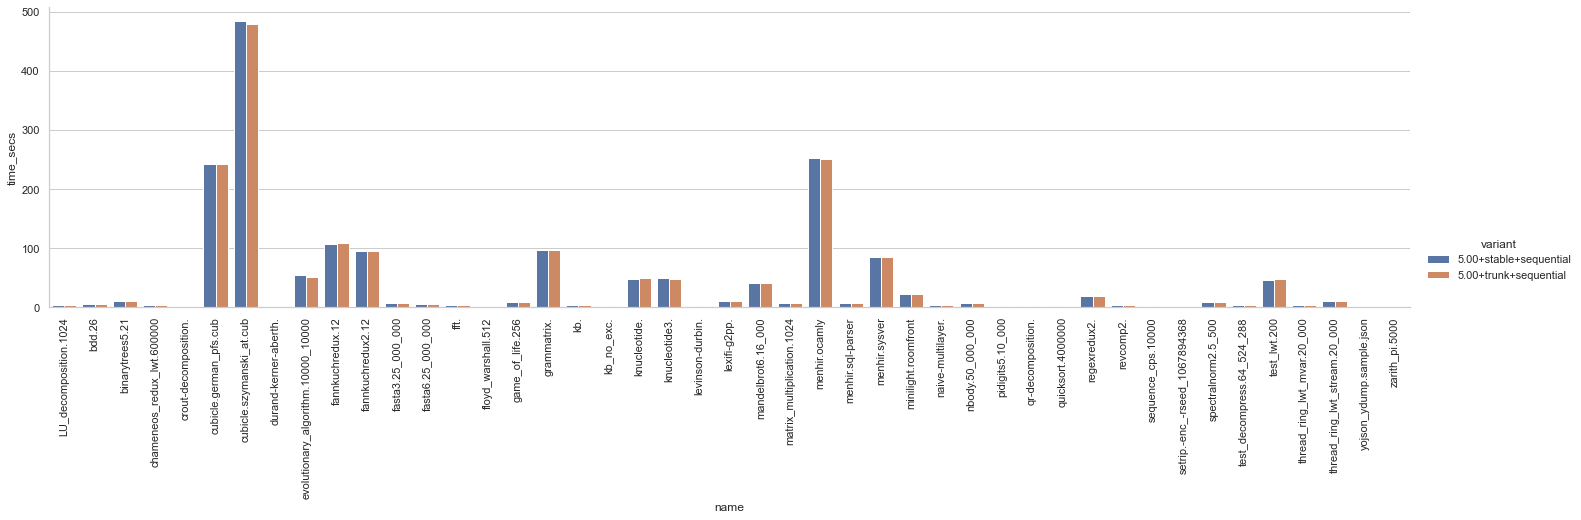

In [46]:
g = sns.catplot (x='name', y='time_secs', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

In [47]:
# returns a dictionary with {key = name : value : metric}
# the metric corresponds to the variant
def create_column(df, variant, metric):
    df = pd.DataFrame.copy(df)
    variant_metric_name = list([ zip(df[metric], df[x], df['name']) 
              for x in df.columns.array if x == "variant" ][0])
    name_metric = {n:t for (t, v, n) in variant_metric_name if v == variant}
#     print(name_metric)
    return name_metric

def add_display_name(df,variant, metric):
    name_metric = create_column(pd.DataFrame.copy(df), variant, metric)
#     print(name_metric)
    disp_name = [name+" ("+str(round(name_metric[name], 2))+")" for name in df["name"]]
    df["display_name"] = pd.Series(disp_name, index=df.index)
    return df

def normalise(df,variant,topic,additionalTopics=[]):
    df = add_display_name(df,variant,topic)
    df = df.sort_values(["name","variant"])
    grouped = df.filter(items=['name',topic,'variant','display_name']+additionalTopics).groupby('variant')
    ndata_frames = []
    for group in grouped:
        (v,data) = group
        if(v != variant):
            data['b'+topic] = grouped.get_group(variant)[topic].values
            data[['n'+topic]] = data[[topic]].div(grouped.get_group(variant)[topic].values, axis=0)
            for t in additionalTopics:
#                 print(variant, t)
                data[[t]] = grouped.get_group(variant)[t].values
            ndata_frames.append(data)
    if ndata_frames:
        df = pd.concat(ndata_frames)
        return df
    else:
        print("need another variant to plot normalized graph")
        return pd.DataFrame()

def plot_normalised(df,variant,topic):
    df = pd.DataFrame.copy(df)
    df.sort_values(by=[topic],inplace=True)
    df[topic] = df[topic] - 1
    g = sns.catplot (x="display_name", y=topic, hue='variant', data = df, kind ='bar', aspect=4, bottom=1)
    g.set_xticklabels(rotation=90)
    g.ax.legend(loc=8)
    g._legend.remove()
    g.ax.set_xlabel("Benchmarks")
    return g
    # g.ax.set_yscale('log')

/var/folders/kt/n9q5lcv93sg3lm2wsrn1kkrw0000gp/T/ipykernel_84126/2810565838.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


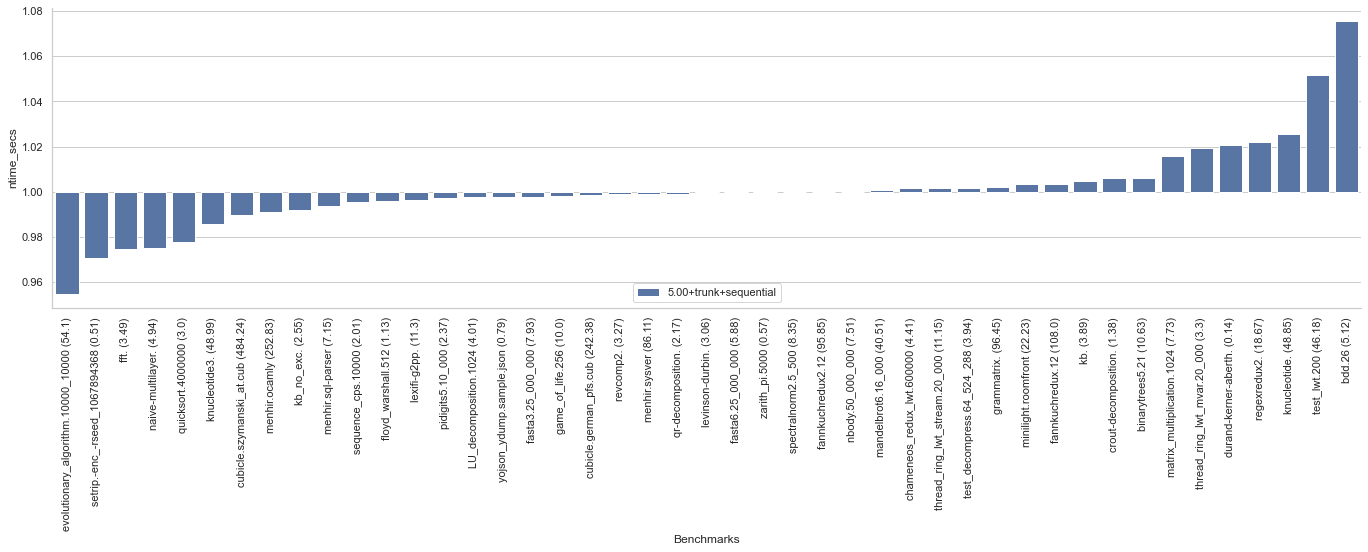

In [48]:
ndf = normalise(df,'5.00+stable+sequential','time_secs')
plot_normalised(ndf,'5.00+stable+sequential','ntime_secs')

## Top heap words

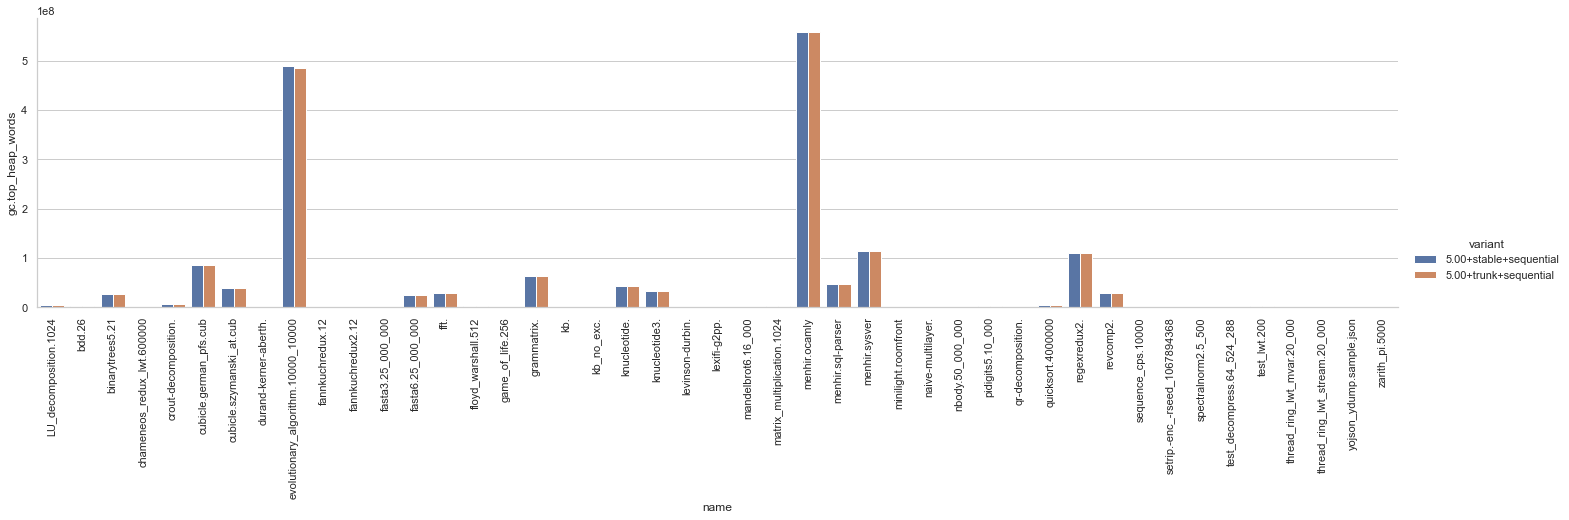

In [49]:
g = sns.catplot (x='name', y='gc.top_heap_words', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

/var/folders/kt/n9q5lcv93sg3lm2wsrn1kkrw0000gp/T/ipykernel_84126/2810565838.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


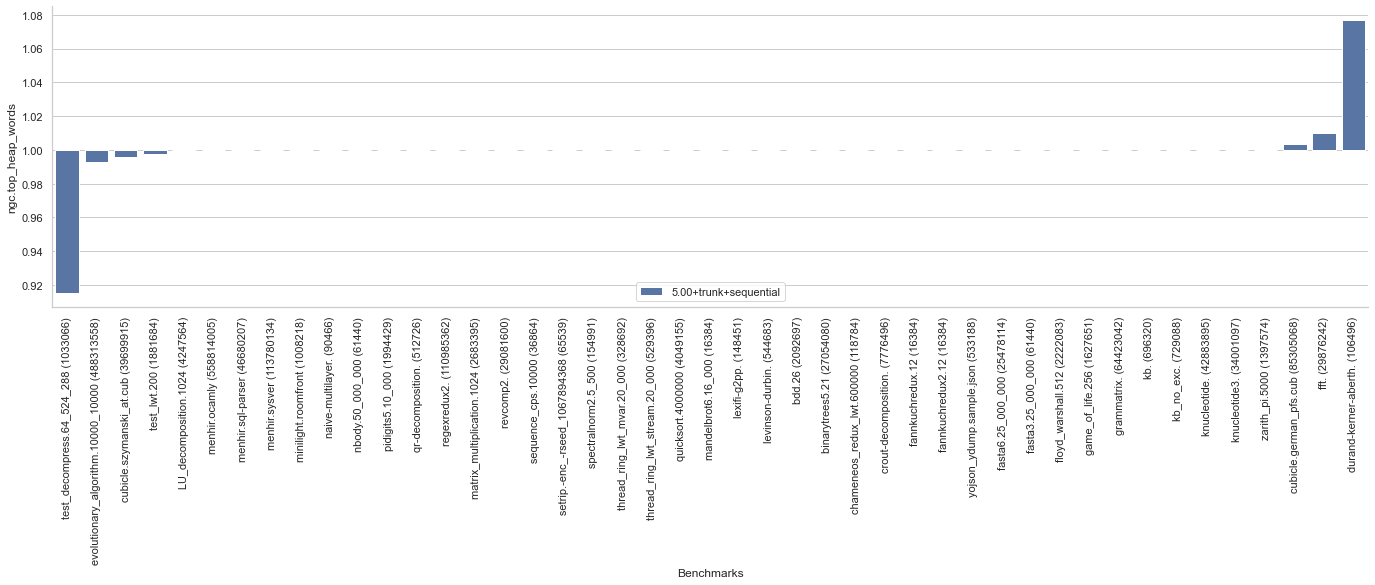

In [50]:
ndf = normalise(df,'5.00+stable+sequential','gc.top_heap_words')
plot_normalised(ndf,'5.00+stable+sequential','ngc.top_heap_words')

## Max RSS (KB)

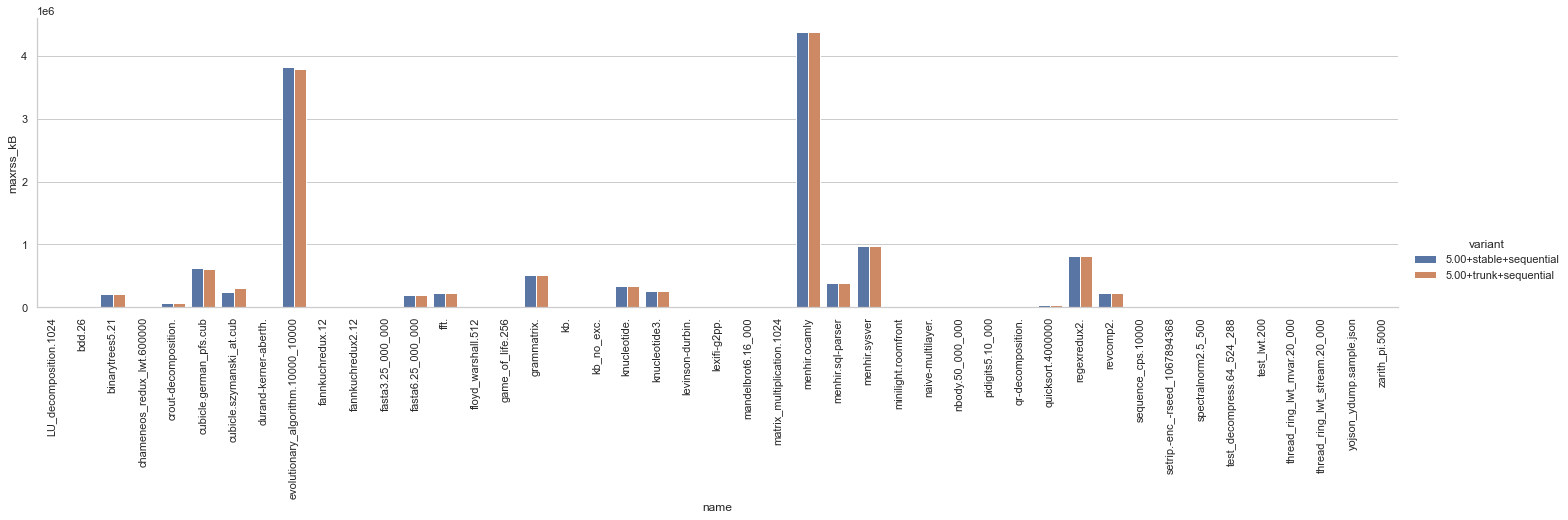

In [51]:
g = sns.catplot (x='name', y='maxrss_kB', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

/var/folders/kt/n9q5lcv93sg3lm2wsrn1kkrw0000gp/T/ipykernel_84126/2810565838.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


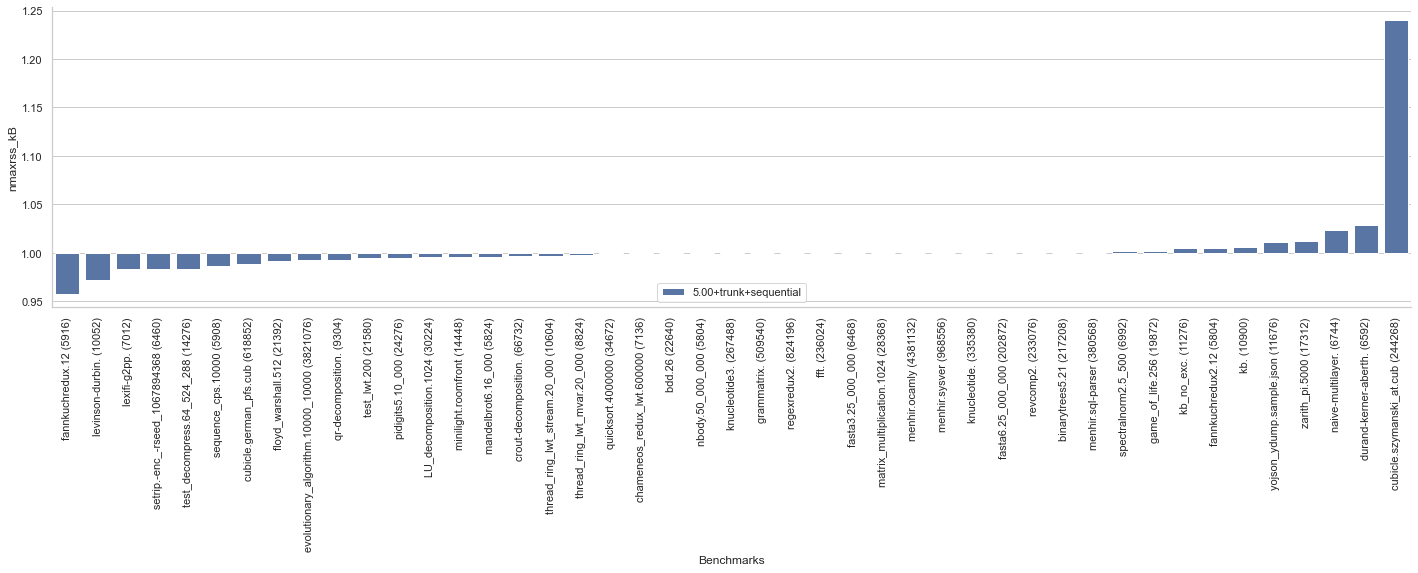

In [52]:
ndf = normalise(df,'5.00+stable+sequential','maxrss_kB')
plot_normalised(ndf,'5.00+stable+sequential','nmaxrss_kB')

## Major Collections

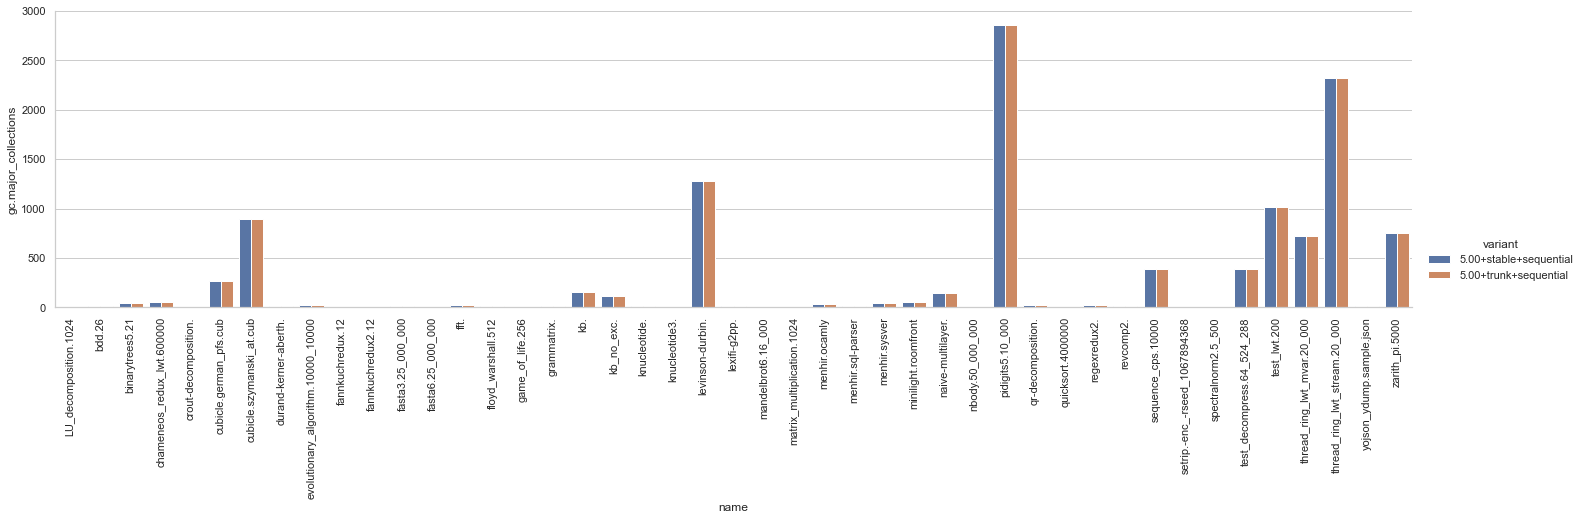

In [53]:
g = sns.catplot (x='name', y='gc.major_collections', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

/var/folders/kt/n9q5lcv93sg3lm2wsrn1kkrw0000gp/T/ipykernel_84126/2810565838.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


,name,gc.major_collections,variant,display_name,bgc.major_collections,ngc.major_collections
9,LU_decomposition.1024,6,5.00+trunk+sequential,LU_decomposition.1024 (6),6,1.000000
31,bdd.26,10,5.00+trunk+sequential,bdd.26 (10),10,1.000000
36,binarytrees5.21,46,5.00+trunk+sequential,binarytrees5.21 (46),46,1.000000
30,chameneos_redux_lwt.600000,52,5.00+trunk+sequential,chameneos_redux_lwt.600000 (52),52,1.000000
7,crout-decomposition.,7,5.00+trunk+sequential,crout-decomposition. (7),7,1.000000
37,cubicle.german_pfs.cub,264,5.00+trunk+sequential,cubicle.german_pfs.cub (264),264,1.000000
23,cubicle.szymanski_at.cub,892,5.00+trunk+sequential,cubicle.szymanski_at.cub (891),891,1.001122
25,durand-kerner-aberth.,12,5.00+trunk+sequential,durand-kerner-aberth. (12),12,1.000000
14,evolutionary_algorithm.10000_10000,24,5.00+trunk+sequential,evolutionary_algorithm.10000_10000 (24),24,1.000000
28,fannkuchredux.12,1,5.00+trunk+sequential,fannkuchredux.12 (1),1,1.000000


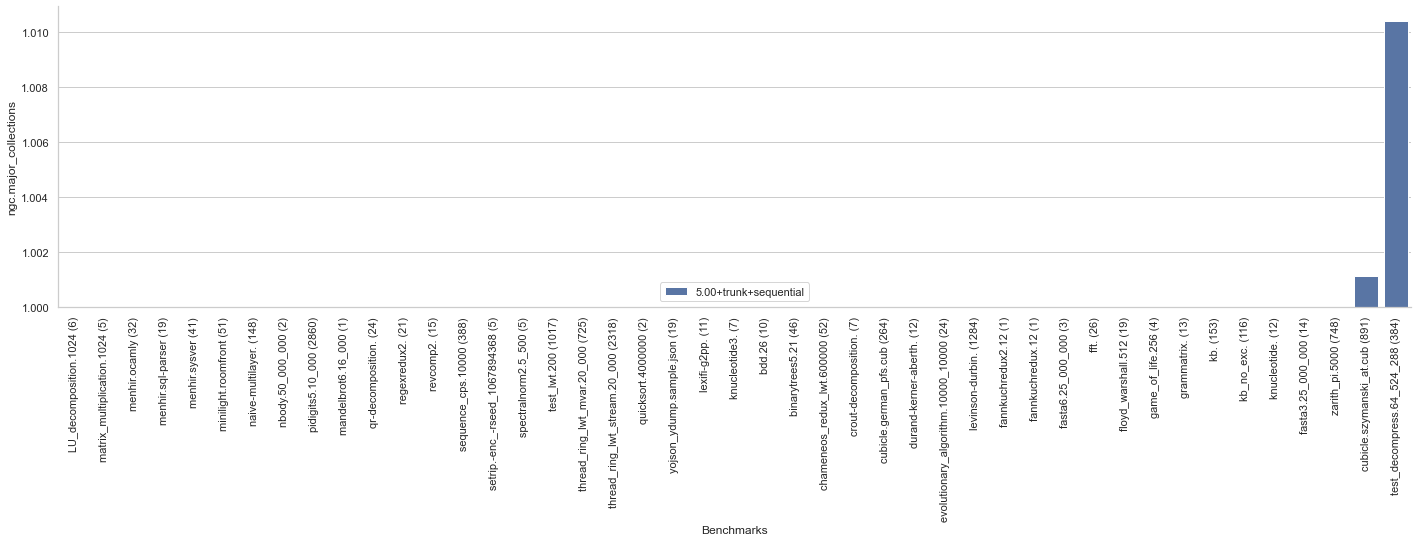

In [54]:
ndf = normalise(df,'5.00+stable+sequential','gc.major_collections')
plot_normalised(ndf,'5.00+stable+sequential','ngc.major_collections')
ndf

## Major words

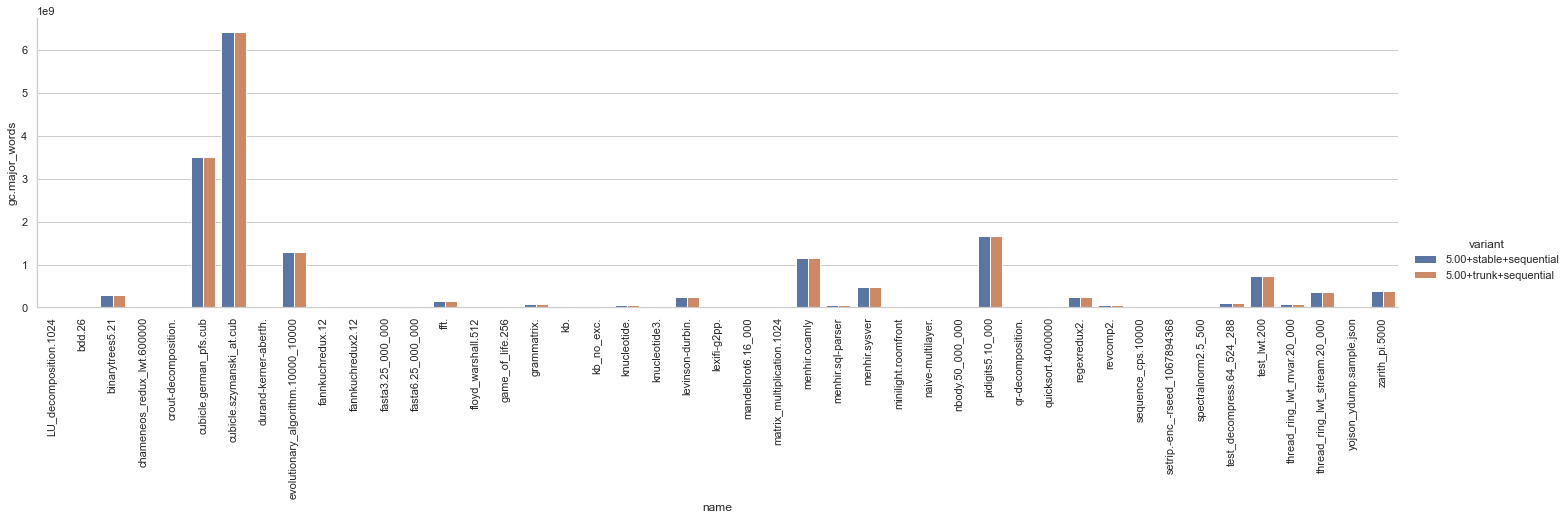

In [55]:
g = sns.catplot (x='name', y='gc.major_words', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

### Normalised

/var/folders/kt/n9q5lcv93sg3lm2wsrn1kkrw0000gp/T/ipykernel_84126/2810565838.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


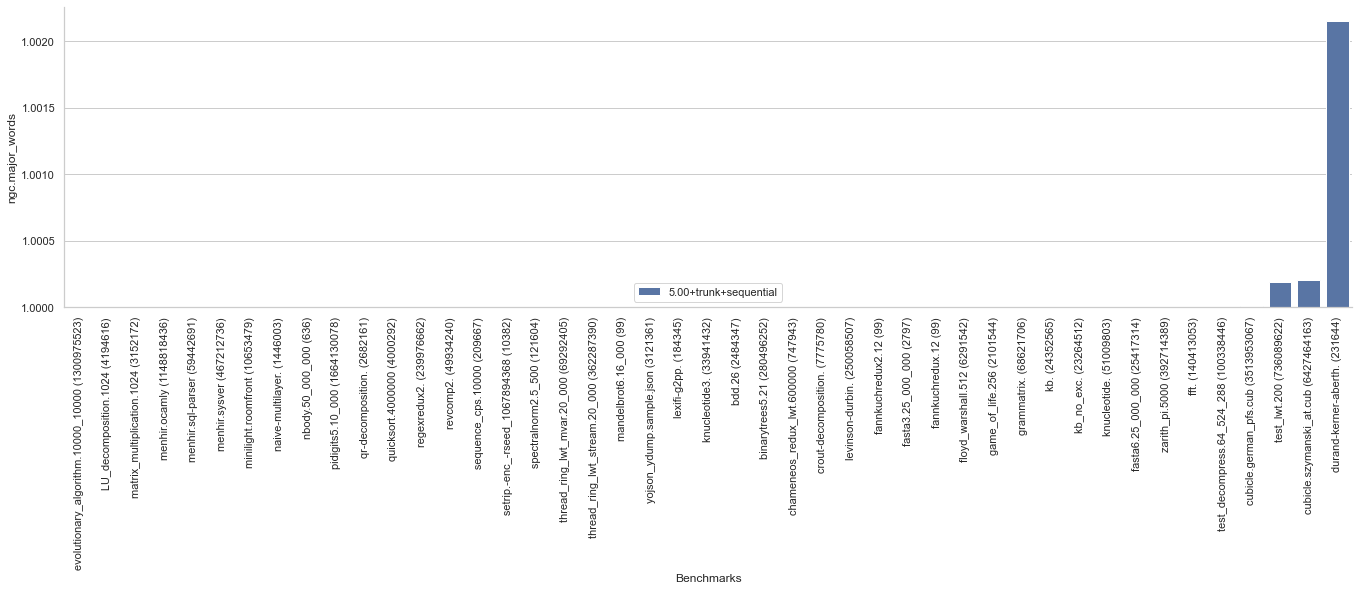

In [56]:
ndf = normalise(df,'5.00+stable+sequential','gc.major_words')
plot_normalised(ndf,'5.00+stable+sequential','ngc.major_words')

## Minor Collections

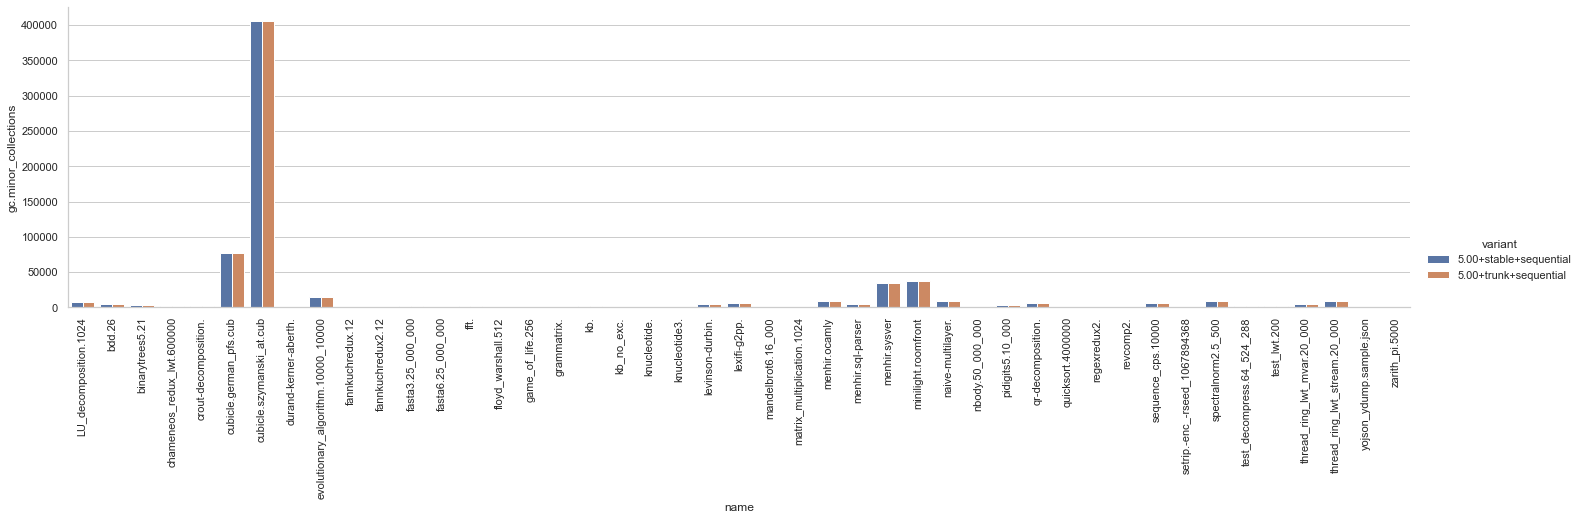

In [57]:
g = sns.catplot (x='name', y='gc.minor_collections', hue='variant', data = df, kind ='bar', aspect=4)
g.set_xticklabels(rotation=90)

/var/folders/kt/n9q5lcv93sg3lm2wsrn1kkrw0000gp/T/ipykernel_84126/2810565838.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


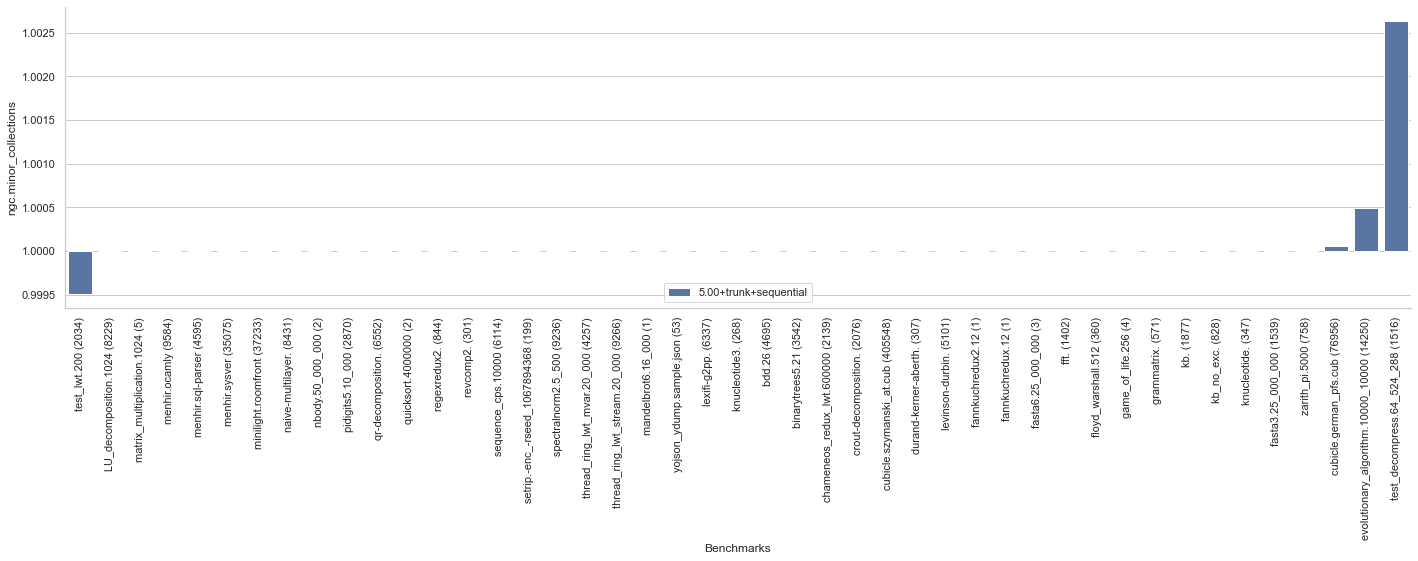

In [58]:
ndf = normalise(df,'5.00+stable+sequential','gc.minor_collections')
plot_normalised(ndf,'5.00+stable+sequential','ngc.minor_collections')

# Latency

In [59]:
data_frames = []

for file in glob.glob("*_1.pausetimes_*.bench"):
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        ldf = pdjson.json_normalize(data)
        ldf['variant'] = file.replace("_1.pausetimes_multicore.bench","").replace("_1.pausetimes_trunk.bench","")
        data_frames.append(ldf)

df2 = pd.concat(data_frames, sort=False)
df2 = df2.sort_values(['name'])

## Drop some benchmarks
df2 = df2[(df2.name != 'alt-ergo.fill.why') & #multicore version does not exist
        (df2.name != 'alt-ergo.yyll.why') & #multicore version does not exist
        (df2.name != 'frama-c.slevel') &    #multicore version does not exist
        (df2.name != 'js_of_ocaml.frama-c_byte') &    #multicore version does not exist
        (df2.name != 'cpdf.merge')]         #Not a macro benchmark. Will be removed from subsequent runs.
df2.count()
latency_df = df2
df2

ValueError: No objects to concatenate

The latency distributions `distr_latency` are a list of latencies at `[10,20,30,40,50,60,70,80,90,95,99,99.9]`th percentiles.

## Max latency

In [ ]:
df2.filter(["name","variant","max_latency"])

,name,variant,max_latency
0,LU_decomposition.1024,4.12.0+domains+effects+instrumented_1.pausetim...,162355
0,LU_decomposition.1024,4.12.0+stock+instrumented_1.pausetimes_trunk.s...,13812
30,bdd.26,4.12.0+stock+instrumented_1.pausetimes_trunk.s...,14424788
26,bdd.26,4.12.0+domains+effects+instrumented_1.pausetim...,5554952
9,binarytrees5.21,4.12.0+domains+effects+instrumented_1.pausetim...,13913467
...,...,...,...
24,thread_ring_lwt_stream.20_000,4.12.0+stock+instrumented_1.pausetimes_trunk.s...,3256686
50,yojson_ydump.sample.json,4.12.0+stock+instrumented_1.pausetimes_trunk.s...,1484245
43,yojson_ydump.sample.json,4.12.0+domains+effects+instrumented_1.pausetim...,721518
46,zarith_pi.5000,4.12.0+stock+instrumented_1.pausetimes_trunk.s...,866921


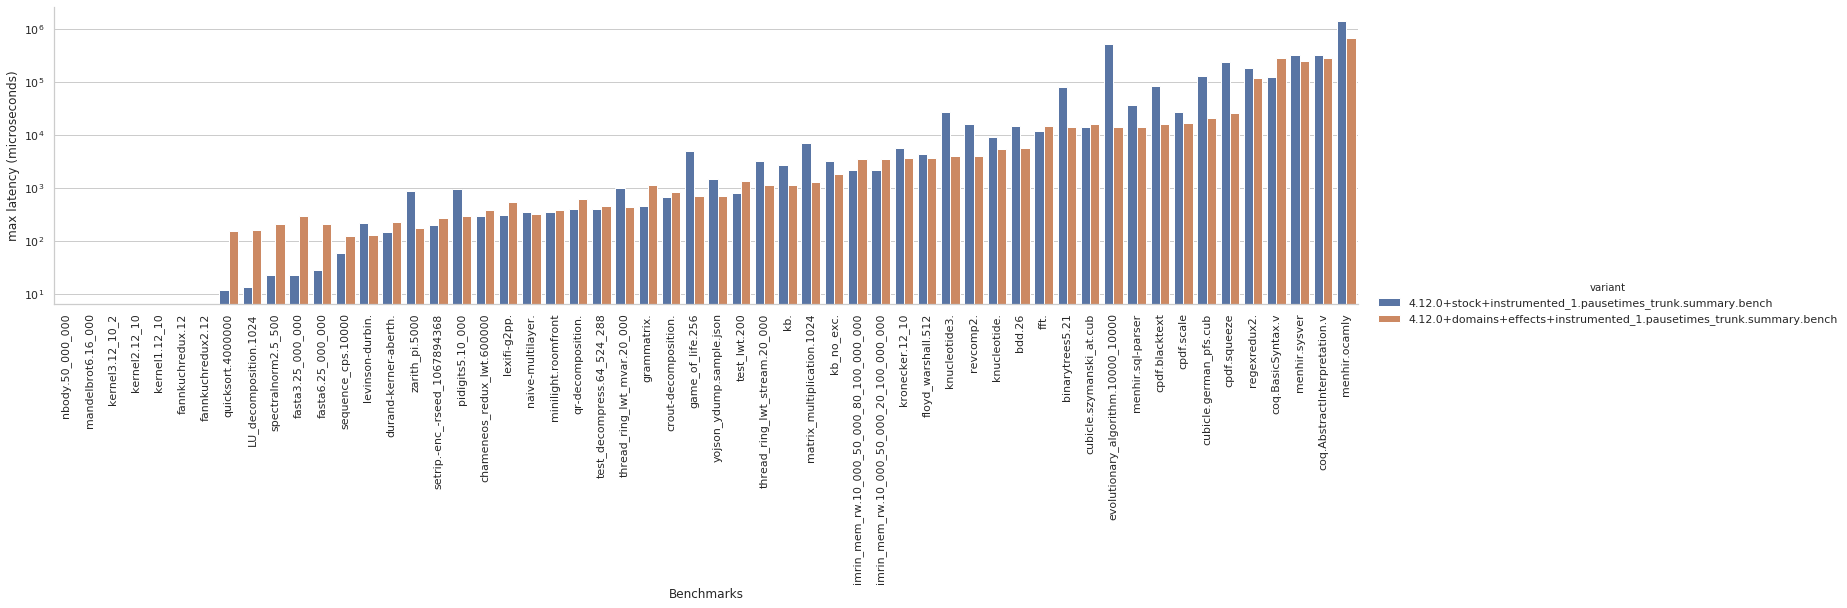

In [ ]:
def plotLatencyAt(df,at,aspect):
    fdf = df.filter(["name","variant",at + "_latency"])
    fdf.sort_values(by=[at + '_latency'],inplace=True)
    fdf[at + "_latency"] = fdf[at + "_latency"] / 1000.0
    g = sns.catplot (x='name', y=at+'_latency', hue='variant', data = fdf, kind ='bar', aspect=aspect)
    g.set_xticklabels(rotation=90)
    g.ax.set_ylabel(at + " latency (microseconds)")
    g.ax.set_xlabel("Benchmarks")
    g.ax.set_yscale('log')
    return g

plotLatencyAt(df2,"max",4)

## 99.9th percentile latency

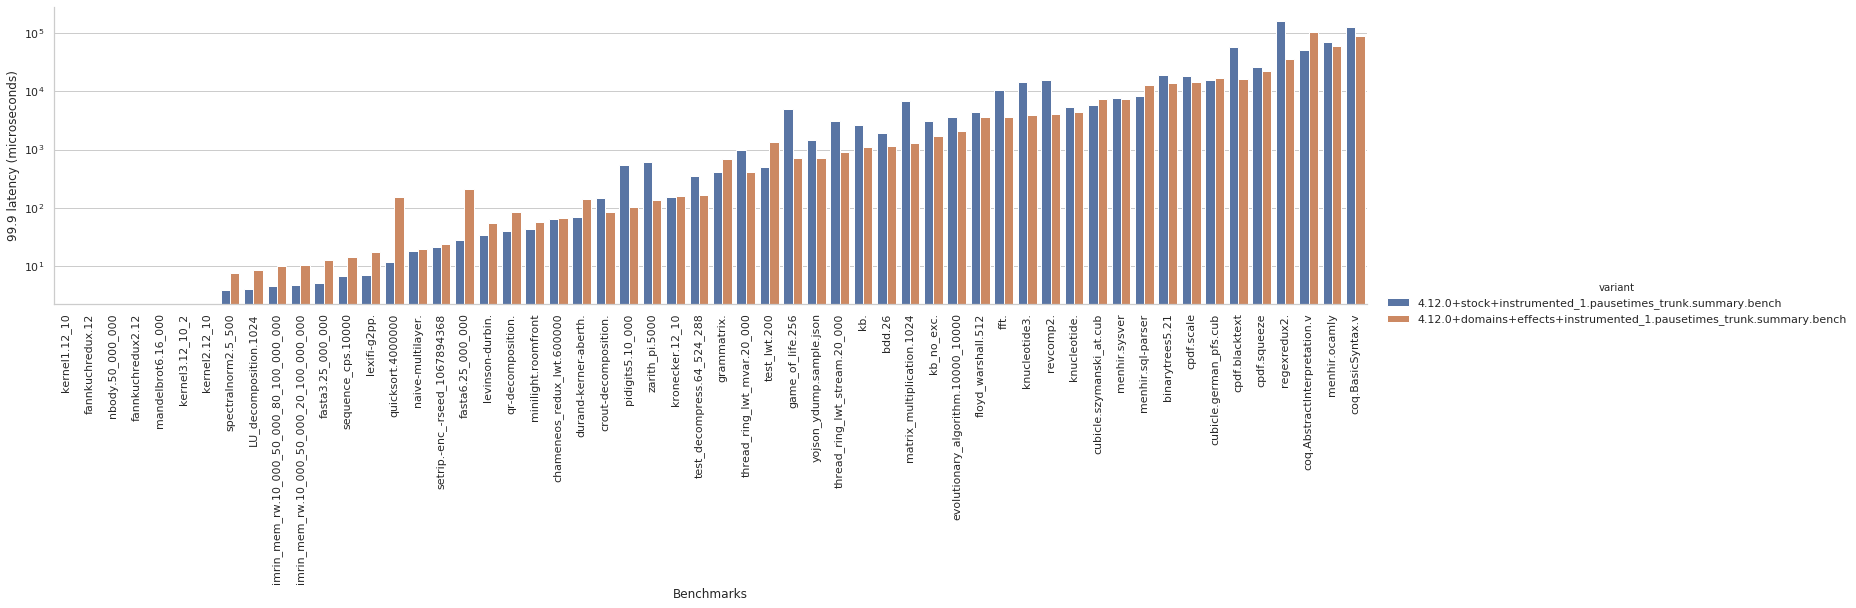

In [ ]:
def getLatencyAt(df,percentile,idx):
    groups = df.groupby('variant')
    ndfs = []
    for group in groups:
        (v,df) = group
        for i, row in df.iterrows():
            df.at[i,percentile+"_latency"] = list(df.at[i,"distr_latency"])[idx]
        ndfs.append(df)
    return pd.concat(ndfs)

df2 = getLatencyAt(df2,"99.9",-1)
plotLatencyAt(df2,"99.9",4)

## 99th percentile latency

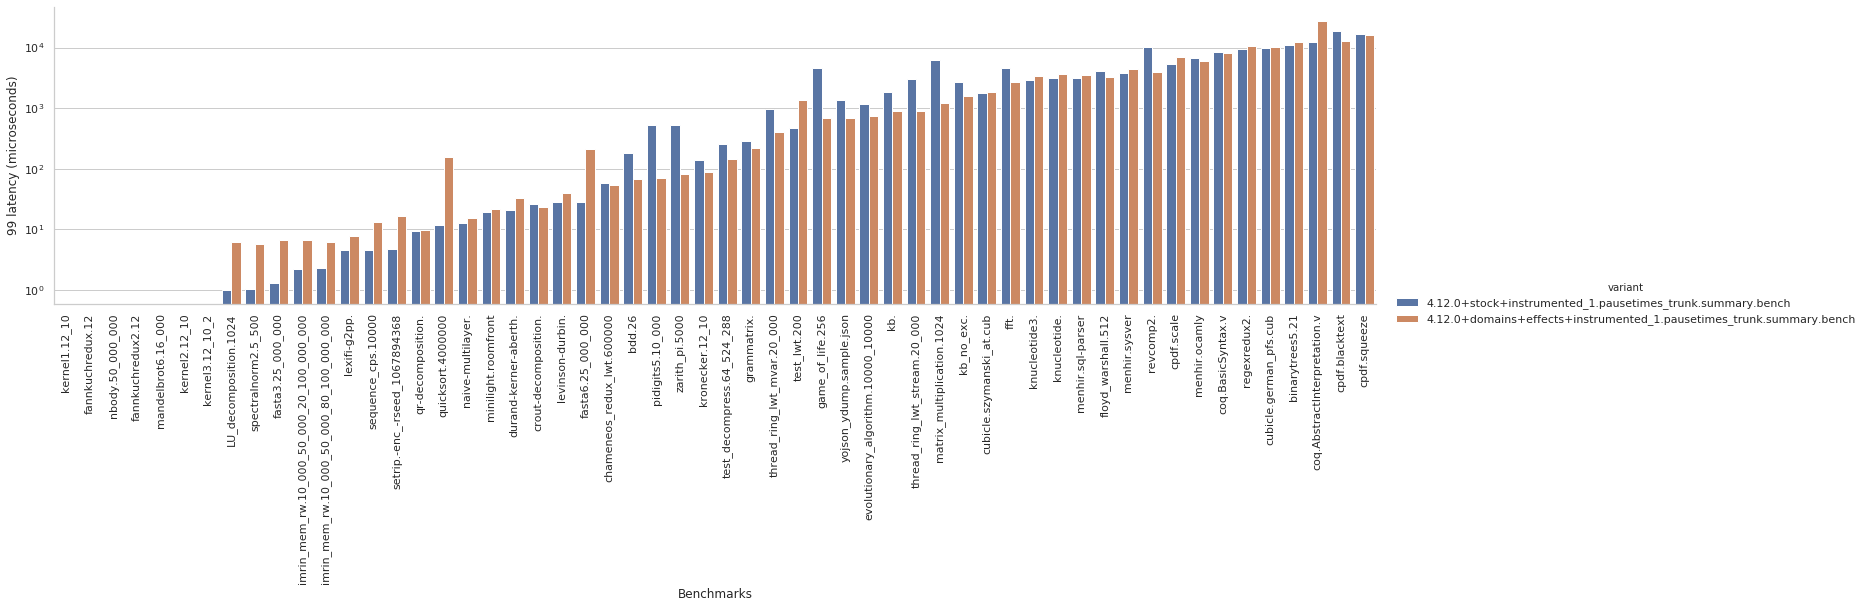

In [ ]:
df2 = getLatencyAt(df2,"99",-2)
plotLatencyAt(df2,"99",4)